# Bicycle Inventory Dynamics - Part 1

In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.path.abspath("."), os.pardir)))

from dataclasses import dataclass
import heapq
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
import seaborn as sns

from rl.distributions import Categorical, FiniteDistribution
from rl.markov_process import FiniteMarkovProcess

In [2]:
@dataclass(frozen=True)
class Inventory:
    on_hand: int  # how much exists in the inventory by 6 pm
    on_order: int  # how much will arrive next day at 6 am

    @property
    def inventory_position(self) -> int:
        return self.on_hand + self.on_order


class BicycleInventoryFiniteMP(FiniteMarkovProcess[Inventory]):
    def __init__(self, capacity: int, poisson_lambda: float):
        self.capacity: int = capacity
        self.poisson_lambda: float = poisson_lambda
        self.poisson_dist = poisson(poisson_lambda)
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> dict[Inventory, FiniteDistribution[Inventory]]:
        dist: dict[Inventory, Categorical[Inventory]] = {}

        for alpha in range(self.capacity + 1):
            for beta in range(self.capacity + 1 - alpha):
                source_inventory = Inventory(on_hand=alpha, on_order=beta)
                total_inventory = source_inventory.inventory_position
                leftover_capacity = self.capacity - total_inventory

                probabilities: dict[Inventory, float] = {
                    # destination state
                    Inventory(
                        on_hand=total_inventory - customer_demand,
                        on_order=leftover_capacity,
                    ): (
                        # if there's more possible to order,
                        # then calculate prob of customer demand
                        self.poisson_dist.pmf(customer_demand)
                        if customer_demand < total_inventory
                        # if customers buy all available bicycles
                        # then calculate demand prob accordingly
                        else 1.0 - self.poisson_dist.cdf(total_inventory - 1)
                    )
                    for customer_demand in range(total_inventory + 1)
                }

                dist[source_inventory] = Categorical(probabilities)

        return dist

In [3]:
mp = BicycleInventoryFiniteMP(capacity=6, poisson_lambda=5.0)

# print out the transition probabilities
print(mp)

From State Inventory(on_hand=0, on_order=0):
	To State Inventory(on_hand=0, on_order=6) with Probability 1.000
From State Inventory(on_hand=0, on_order=1):
	To State Inventory(on_hand=1, on_order=5) with Probability 0.007
	To State Inventory(on_hand=0, on_order=5) with Probability 0.993
From State Inventory(on_hand=0, on_order=2):
	To State Inventory(on_hand=2, on_order=4) with Probability 0.007
	To State Inventory(on_hand=1, on_order=4) with Probability 0.034
	To State Inventory(on_hand=0, on_order=4) with Probability 0.960
From State Inventory(on_hand=0, on_order=3):
	To State Inventory(on_hand=3, on_order=3) with Probability 0.007
	To State Inventory(on_hand=2, on_order=3) with Probability 0.034
	To State Inventory(on_hand=1, on_order=3) with Probability 0.084
	To State Inventory(on_hand=0, on_order=3) with Probability 0.875
From State Inventory(on_hand=0, on_order=4):
	To State Inventory(on_hand=4, on_order=2) with Probability 0.007
	To State Inventory(on_hand=3, on_order=2) with P

What does the stationary distribution look like?

In [4]:
stationary_dist = mp.compute_stationary_distribution()
top_k_states = heapq.nlargest(3, iterable=stationary_dist, key=lambda x: x[1])

for state, prob in top_k_states:
    print(f"State {state}: probability = {prob:.3f}")

State Inventory(on_hand=0, on_order=3): probability = 0.345
State Inventory(on_hand=0, on_order=4): probability = 0.200
State Inventory(on_hand=0, on_order=2): probability = 0.193


Conclusion:         
In the long run, the store will most likely have an empty stock (`on_hard = 0`) and will receive 3 more cycles next day (`on_order = 3`).

In [5]:
stats = pd.DataFrame(
    {
        "On Hand": [s.on_hand for s, _ in stationary_dist],
        "On Order": [s.on_order for s, _ in stationary_dist],
        "prob": [p for _, p in stationary_dist],
    }
).pivot(index="On Hand", columns="On Order", values="prob")

stats.head()

On Order,0,1,2,3,4,5,6
On Hand,,,,,,,
0,0.004183,0.042748,0.192725,0.344536,0.199632,0.044358,0.004183
1,0.001911,0.013406,0.036809,0.033151,0.007009,0.000301,NaN
2,0.001911,0.010725,0.022085,0.013260,0.001402,NaN,NaN
3,0.001529,0.006435,0.008834,0.002652,NaN,NaN,NaN
4,0.000917,0.002574,0.001767,NaN,NaN,NaN,NaN


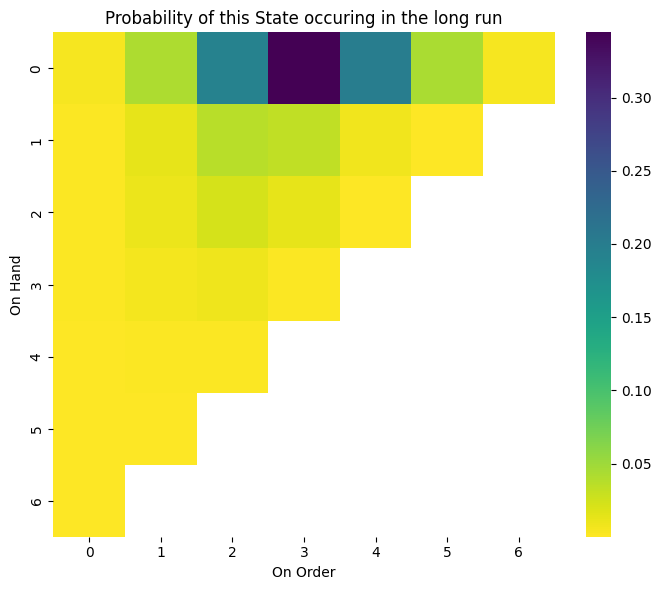

In [6]:
plt.subplots(figsize=(7, 6))

sns.heatmap(data=stats, cmap="viridis_r")
plt.title("Probability of this State occuring in the long run")

plt.tight_layout()
plt.show()